# Example: Neural Networks with partitions

Before runnning this notebook, make sure that all neccesary libraries are installed:

In [1]:
using Flux
using Flux: Chain, Dense, relu, mse, train!, params, ADAM
using Random
using Gogeta
using Plots
using Gurobi
using JuMP
using LaTeXStrings
using CSV
using DataFrames
using StatsBase

## Introduction

In this Jupyter notebook, we present a different way how to represent neural networks as a MIP problem. The approach uses partition-based formulations, and based on the follwing paper [[1]](https://arxiv.org/abs/2102.04373). The idea is that variables are split into $N$ non-overlapping sets. We are interested in the smallest $N$ such that the bounds for the variables are as tight as possible.

## Initialize neural network with random weights

At first, lets inntialize the neural network with the random weights. This network will be exactly the same as in the original example of neural networks. In this way we will be able to see the difference in computational performance between formulations. After that we will switch to bigger model. 

In [2]:
# Create a small neural network with random weights
begin
    Random.seed!(1234);

    NN_model = Chain(
        Dense(8 => 64, relu),
        Dense(64 => 32, relu),
        Dense(32 => 1)
    )
end

init_U = [-0.5, 0.5,-0.5, 0.5, -0.5, 0.5,-0.5, 0.5];
init_L = [-1.5, -0.5,-0.5, 0.5, -1.5, -0.5,-0.5, 0.5];

# THIS SHOULD BE REMOVED

In [3]:
function Psplits(w::AbstractVector, P::Integer, strategy::String)

    parts = Vector{Vector{Int64}}(undef, P)

    if strategy=="equalsize"

        X = sortperm(w)
        l = length(X)
        n = l % P

        s2 = (l÷P)

        if n > 0
            s1 = (l÷P)+1
            for k in 1:n
                parts[k] = X[1+(k-1)*s1:(k-1)*s1+s1]
            end
        else
            s1 = 0
        end
        
        for k in n+1:P
            parts[k] = X[1+n*s1+(k-1-n)*s2:n*s1+(k-1-n)*s2+s2]
        end
      
    end
    if strategy=="equalrange"
        # Define the thresholds v
        v = Vector{Float64}(undef, P + 1)
        v[1] =  minimum(w)
        v[P+1] = maximum(w)
        v[2:P] = collect(range(quantile(w, 0.05), quantile(w, 0.95), P-1))

        # Assign indices to partitions S_n
        for i in 1:P
            parts[i] = []
        end
    
        for (index, weight) in enumerate(w)
            for i in 1:P
                if weight >= v[i] && weight <= v[i+1]
                    push!(parts[i], index)
                    break
                end
            end
        end
    end

    if strategy=="random"

        for i in 1:P
            parts[i] = []
        end

        for (index, weight) in enumerate(w)
            i = rand(1:P)
            push!(parts[i], index)
        end

    end
    
    
    parts = [s for s in parts if !all(isempty.(s))]

    return parts
end

function NN_formulate_Psplit!(jump_model::JuMP.Model, NN_model::Flux.Chain, P, init_U, init_L; strategy="equalsize", silent=true)

    oldstdout = stdout
    if silent redirect_stdout(devnull) end

    if !(strategy in ["equalrange", "equalsize", "random"])
        throw(ArgumentError("Possible strategy options: \"equalrange\", \"equalsize\", \"random\""))
    end
    if strategy=="equalrange" && P<=2
        throw(ArgumentError("With equalrange strategy number of partitions P>2"))
    end
        
    println("Creating JuMP model...")
    empty!(jump_model)

    K = length(NN_model); # number of layers (input layer not included)
    W = deepcopy([Flux.params(NN_model)[2*k-1] for k in 1:K]);
    b = deepcopy([Flux.params(NN_model)[2*k] for k in 1:K]);


    @assert all([NN_model[i].σ == relu for i in 1:K-1]) "Neural network must use the relu activation function."
    @assert NN_model[K].σ == identity "Neural network must use the identity function for the output layer."
    @assert P > 0 "The number of splits must be more than 0."

    input_length = Int((length(W[1]) / length(b[1])))
    neuron_count = [length(b[k]) for k in eachindex(b)]
    neurons(layer) = layer == 0 ? [i for i in 1:input_length] : [i for i in 1:neuron_count[layer]]

    @variable(jump_model, x[layer = 0:K, neurons(layer)]);
    @variable(jump_model, sigma[layer = 1:K-1, neurons(layer)]);
    @variable(jump_model, z_b[layer = 1:K-1, neurons(layer), p=1:P]);

    @constraint(jump_model, [j = 1:input_length], x[0, j] <= init_U[j])
    @constraint(jump_model, [j = 1:input_length], x[0, j] >= init_L[j])

    bounds_U = Vector{Vector}(undef, K)
    bounds_L = Vector{Vector}(undef, K)

    UB_α = Vector{Vector{Vector}}(undef, K-1)
    LB_α = Vector{Vector{Vector}}(undef, K-1)

    [UB_α[layer] = Vector{Vector}(undef, neuron_count[layer]) for layer in 1:K-1]
    [LB_α[layer] = Vector{Vector}(undef, neuron_count[layer]) for layer in 1:K-1]

    for layer in 1:K 

        println("\nLAYER $layer")

        if layer == 1

            bounds_U[layer] = [sum(max(W[layer][neuron, previous] * init_U[previous], W[layer][neuron, previous] * init_L[previous]) for previous in neurons(layer-1)) + b[layer][neuron] for neuron in neurons(layer)]
            bounds_L[layer] = [sum(min(W[layer][neuron, previous] * init_U[previous], W[layer][neuron, previous] * init_L[previous]) for previous in neurons(layer-1)) + b[layer][neuron] for neuron in neurons(layer)]
        else
            
            bounds_U[layer] = [sum(bounds_U[layer-1][previous]*max(0, W[layer][neuron, previous]) + bounds_L[layer-1][previous]*min(0, W[layer][neuron, previous]) for previous in neurons(layer-1)) + b[layer][neuron] for neuron in neurons(layer)]
            bounds_L[layer] = [sum(bounds_L[layer-1][previous]*max(0, W[layer][neuron, previous]) + bounds_U[layer-1][previous]*min(0, W[layer][neuron, previous]) for previous in neurons(layer-1)) + b[layer][neuron] for neuron in neurons(layer)]
        end

        # output bounds calculated but no more constraints added
        if layer == K
            break
        end

        [UB_α[layer][neuron] = Vector(undef, P) for neuron in 1:neuron_count[layer]]
        [LB_α[layer][neuron] = Vector(undef, P) for neuron in 1:neuron_count[layer]]

        @constraint(jump_model, [neuron in neurons(layer)], x[layer, neuron] <= max(0, bounds_U[layer][neuron]))
        @constraint(jump_model, [neuron in neurons(layer)], x[layer, neuron] >= 0)

        for neuron in neurons(layer)

            split_indices = Psplits(W[layer][neuron, :], P, strategy)
            set_binary(sigma[layer, neuron])
            
            @constraint(jump_model, sum(sum(W[layer][neuron, i]*x[layer-1, i] for i in split_indices[p])-z_b[layer, neuron, p] for p in eachindex(split_indices)) + sigma[layer, neuron]*b[layer][neuron]<=0)
            @constraint(jump_model, sum(z_b[layer, neuron, p] for p in  eachindex(split_indices)) + (1-sigma[layer,neuron])*b[layer][neuron]>=0)
            @constraint(jump_model, x[layer, neuron] == sum(z_b[layer, neuron, p] for p in eachindex(split_indices)) + (1-sigma[layer,neuron])*b[layer][neuron]) 
            
            for p in eachindex(split_indices)
            
                if layer == 1
                    UB_α[layer][neuron][p] = sum(max(W[layer][neuron, previous] * init_U[previous], W[layer][neuron, previous] * init_L[previous]) for previous in split_indices[p])
                    LB_α[layer][neuron][p] = sum(min(W[layer][neuron, previous] * init_U[previous], W[layer][neuron, previous] * init_L[previous]) for previous in split_indices[p])
                else
                    UB_α[layer][neuron][p] = sum(max(W[layer][neuron, previous] * max(0, bounds_U[layer-1][previous]), W[layer][neuron, previous] * max(0, bounds_L[layer-1][previous])) for previous in split_indices[p])
                    LB_α[layer][neuron][p] = sum(min(W[layer][neuron, previous] * max(0, bounds_U[layer-1][previous]), W[layer][neuron, previous] * max(0, bounds_L[layer-1][previous])) for previous in split_indices[p])
                end
                
                @constraint(jump_model, sigma[layer, neuron]*LB_α[layer][neuron][p]<=sum(W[layer][neuron, i]*x[layer-1, i] for i in split_indices[p])-z_b[layer, neuron, p])
                @constraint(jump_model, sum(W[layer][neuron, i]*x[layer-1, i] for i in split_indices[p])-z_b[layer, neuron, p]<=sigma[layer, neuron]*UB_α[layer][neuron][p]) 
                @constraint(jump_model, (1-sigma[layer, neuron])*LB_α[layer][neuron][p]<=z_b[layer, neuron, p])
                @constraint(jump_model, z_b[layer, neuron, p]<=(1-sigma[layer, neuron])*UB_α[layer][neuron][p])

            end
        end
    end

    # output layer
    @constraint(jump_model, [neuron in neurons(K)], x[K, neuron] <= max(0, bounds_U[K][neuron]))
    @constraint(jump_model, [neuron in neurons(K)], x[K, neuron] >= min(0, bounds_L[K][neuron]))
    @constraint(jump_model, [neuron in neurons(K)], x[K, neuron] == b[K][neuron] + sum(W[K][neuron, i] * x[K-1, i] for i in neurons(K-1)))

    #A dummy objective
    @objective(jump_model, Max, 1);

    redirect_stdout(oldstdout)

    return bounds_U, bounds_L
    
end


NN_formulate_Psplit! (generic function with 1 method)

## Formulation of NN as a MIP using partiiton-based formulation

Once we have "trained" neural network, we need to innitialize empty `JuMp` model with `Gurobi`.


In [4]:
jump_model_1 = Model(Gurobi.Optimizer);
set_silent(jump_model_1) #disables output of the optimazer
set_attribute(jump_model_1, "TimeLimit", 10) #sets the time limit to be 10 seconds

jump_model_2 = Model(Gurobi.Optimizer);
set_silent(jump_model_2) #disables output of the optimazer
set_attribute(jump_model_2, "TimeLimit", 10) #sets the time limit to be 10 seconds

jump_model_3 = Model(Gurobi.Optimizer);
set_silent(jump_model_3) #disables output of the optimazer
set_attribute(jump_model_3, "TimeLimit", 10) #sets the time limit to be 10 seconds

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-20
Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-20
Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-20


The formulation of NN is done with function `NN_formulate_Psplit!`. It has next set of unput parameters:

- `jump_model`: The constraints and variables will be saved to this optimization model.
- `NN_model`: Neural network model to be formulated.
- `P`: The number of splits
- `init_U`: Upper bounds for the input variables.
- `init_L`: Lower bounds for the input variables.
- `strategy` (optional): the way partitioning is done, possible options include: "equalsize", "equalrange", "random". Default is "equalsize".
- `silent`(optional): Controls console ouput.

There are some restrictions about the strategies for partitioning and architecture of the NN. NN can only have ReLU as activation function and no activation function in the last layer. With "equalrange" partition strategy, number of partitions should be greater or equal than 3. 

In [5]:
P = 3
@time bounds_U_pslit, bounds_L_pslit = NN_formulate_Psplit!(jump_model_1, NN_model, P, init_U, init_L);
@time bounds_U_standart, bounds_L_standart = NN_formulate!(jump_model_2, NN_model, init_U, init_L; bound_tightening="standard", silent=true);
@time bounds_U_fast, bounds_L_fast = NN_formulate!(jump_model_3, NN_model, init_U, init_L; bound_tightening="fast", silent=true);

  4.063905 seconds (8.29 M allocations: 556.095 MiB, 9.34% gc time, 99.50% compilation time: 2% of which was recompilation)
  4.878974 seconds (9.60 M allocations: 645.483 MiB, 4.12% gc time, 70.55% compilation time: 3% of which was recompilation)
  0.005816 seconds (80.47 k allocations: 3.587 MiB)


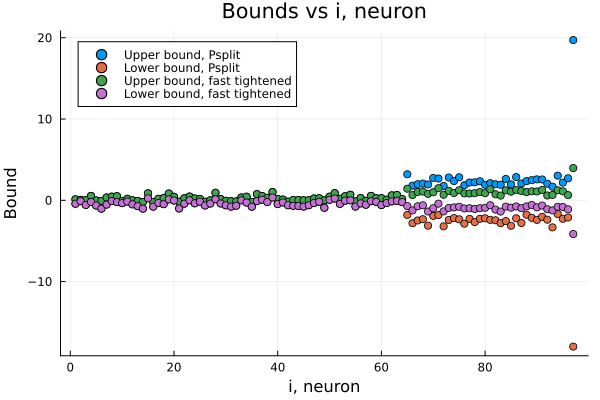

In [6]:
plot(collect(Iterators.flatten(bounds_U_pslit)), xlabel="i, neuron", ylabel="Bound", title="Bounds vs i, neuron",  label = "Upper bound, Psplit", seriestype=:scatter)
plot!(collect(Iterators.flatten(bounds_L_pslit)), label = "Lower bound, Psplit", seriestype=:scatter)
plot!(collect(Iterators.flatten(bounds_U_fast)), label = "Upper bound, fast tightened", seriestype=:scatter)
plot!(collect(Iterators.flatten(bounds_L_fast)), label = "Lower bound, fast tightened", seriestype=:scatter)

In [7]:
jump_model_1, jump_model_2, jump_model_3

(A JuMP Model
Maximization problem with:
Variables: 489
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 97 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 201 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 1353 constraints
`VariableRef`-in-`MathOptInterface.ZeroOne`: 96 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Gurobi
Names registered in the model: sigma, x, z_b, A JuMP Model
Maximization problem with:
Variables: 297
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 97 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 200 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 200 constraints
`VariableRef`-in-`MathOptInterface.ZeroOne`: 96 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: Gurobi
Names registered in the model: s, x, z, A JuMP Model
Maximization problem with:
Varia

Increasing number of partitions will affect size of the Mixed-integer problem.

In [8]:
output_neuron_1 = jump_model_1[:x][maximum(keys(jump_model_1[:x].data))]
output_neuron_2 = jump_model_2[:x][maximum(keys(jump_model_2[:x].data))]
output_neuron_3 = jump_model_3[:x][maximum(keys(jump_model_3[:x].data))]

@objective(jump_model_1, Max, output_neuron_1)
@time optimize!(jump_model_1)

@objective(jump_model_2, Max, output_neuron_2)
@time optimize!(jump_model_2)

@objective(jump_model_3, Max, output_neuron_3)
@time optimize!(jump_model_3)

println("The model with Psplit found next solution:\n", value.(jump_model_1[:x][0, :]))
println("With objective function: ", objective_value(jump_model_1) )
solution = Float32.([i for i in value.(jump_model_1[:x][0, :])])
println("The output of the NN for solution given by jump model: ", NN_model(solution)[1])

  0.882996 seconds (75.81 k allocations: 5.745 MiB, 11.84% compilation time)
  0.069053 seconds (366 allocations: 11.391 KiB)
  0.202616 seconds (5.79 k allocations: 594.062 KiB)
The model with Psplit found next solution:
  [1]  =  -1.5
  [2]  =  -0.5
  [3]  =  -0.5
  [4]  =  0.5
  [5]  =  -1.23878
  [6]  =  -0.5
  [7]  =  -0.5
  [8]  =  0.5
With objective function: 0.7728608512500746
The output of the NN for solution given by jump model: 0.7728607


Due to increased size of the problem, the optimization is slower than with "standart" and "fast" bounding. Now, lets make NN much bigger and see how it affects results

In [9]:
# Create a small neural network with random weights
begin
    Random.seed!(1234);

    NN_model = Chain(
        Dense(16 => 64, relu),
        Dense(64 => 128, relu),
        Dense(128 => 1)
    )
end

init_U = [-0.5, 0.5,-0.5, 0.5, -0.5, 0.5,-0.5, 0.5, -0.5, 0.5,-0.5, 0.5, -0.5, 0.5,-0.5, 0.5];
init_L = [-1.5, -0.5,-0.5, 0.5, -1.5, -0.5,-0.5, 0.5, -1.5, -0.5,-0.5, 0.5, -1.5, -0.5,-0.5, 0.5];

Now, if we want to use a different partition strategy, for example "equalrange", we can put it as an optional parameter

In [25]:
P = 3

@time bounds_U_pslit, bounds_L_pslit = NN_formulate_Psplit!(jump_model_1, NN_model, P, init_U, init_L);


  0.122660 seconds (1.90 M allocations: 71.402 MiB, 4.80% gc time)


In [11]:
@time bounds_U_standart, bounds_L_standart = NN_formulate!(jump_model_2, NN_model, init_U, init_L; bound_tightening="standard", silent=true);

 28.916741 seconds (1.47 M allocations: 85.163 MiB, 0.04% gc time, 1.39% compilation time)


┌ Warning: Layer 3, neuron 1 could not be solved to optimality.
└ @ Gogeta ~/.julia/packages/Gogeta/iJMCg/src/neural_networks/bounds.jl:40


In [12]:
@time bounds_U_fast, bounds_L_fast = NN_formulate!(jump_model_3, NN_model, init_U, init_L; bound_tightening="fast", silent=true);

  0.019731 seconds (275.87 k allocations: 11.572 MiB)


In [13]:
output_neuron_1 = jump_model_1[:x][maximum(keys(jump_model_1[:x].data))]
output_neuron_2 = jump_model_2[:x][maximum(keys(jump_model_2[:x].data))]
output_neuron_3 = jump_model_3[:x][maximum(keys(jump_model_3[:x].data))]

@objective(jump_model_1, Max, output_neuron_1)
@time optimize!(jump_model_1)

@objective(jump_model_2, Max, output_neuron_2)
@time optimize!(jump_model_2)

@objective(jump_model_3, Max, output_neuron_3)
@time optimize!(jump_model_3)

 10.033307 seconds (38.33 k allocations: 4.226 MiB)
  2.856982 seconds (10.16 k allocations: 317.516 KiB)
 10.023840 seconds (19.70 k allocations: 1.553 MiB)


Optimization with standart bounds takes much more time to formulate as a MIP, but optimization is faster. Formulstion with partitions performs is almost the same as with "fast" bounda.

In [14]:
# Create a small neural network with random weights
begin
    Random.seed!(1234)

    NN_model = Chain(
        Dense(16 => 128, relu),
        Dense(128 => 256, relu),
        Dense(256 => 1)
    )
end

init_U = [-0.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5];
init_L = [-1.5, -0.5, -0.5, 0.5, -1.5, -0.5, -0.5, 0.5, -1.5, -0.5, -0.5, 0.5, -1.5, -0.5, -0.5, 0.5];

In [22]:
P = 4

@time bounds_U_pslit, bounds_L_pslit = NN_formulate_Psplit!(jump_model_1, NN_model, P, init_U, init_L);
@time bounds_U_fast, bounds_L_fast = NN_formulate!(jump_model_3, NN_model, init_U, init_L; bound_tightening="fast", silent=true);

  0.120672 seconds (1.95 M allocations: 60.785 MiB)
  0.085453 seconds (992.53 k allocations: 33.553 MiB, 15.16% gc time)


In [23]:
output_neuron_1 = jump_model_1[:x][maximum(keys(jump_model_1[:x].data))]
output_neuron_3 = jump_model_3[:x][maximum(keys(jump_model_3[:x].data))]

@objective(jump_model_1, Max, output_neuron_1)
@time optimize!(jump_model_1)

@objective(jump_model_3, Max, output_neuron_3)
@time optimize!(jump_model_3)

 10.021512 seconds (77.47 k allocations: 11.302 MiB)
 10.009915 seconds (23.59 k allocations: 3.250 MiB)


In [18]:
@time NN_formulate_Psplit!(jump_model_1, NN_model, P, init_U, init_L);
@time NN_formulate_Psplit!(jump_model_2, NN_model, P, init_U, init_L, strategy = "equalrange");
@time NN_formulate_Psplit!(jump_model_3, NN_model, P, init_U, init_L, strategy = "random");


  0.128031 seconds (1.95 M allocations: 60.785 MiB, 7.08% gc time)
  0.143642 seconds (1.96 M allocations: 70.574 MiB, 16.99% gc time, 2.68% compilation time)
  0.123798 seconds (1.95 M allocations: 61.849 MiB, 6.73% gc time)


In [20]:
output_neuron = jump_model_1[:x][maximum(keys(jump_model_1[:x].data))]
@objective(jump_model_1, Max, output_neuron);
@time optimize!(jump_model_1)

output_neuron = jump_model_2[:x][maximum(keys(jump_model_2[:x].data))]
@objective(jump_model_2, Max, output_neuron);
@time optimize!(jump_model_2)

output_neuron = jump_model_3[:x][maximum(keys(jump_model_3[:x].data))]
@objective(jump_model_3, Max, output_neuron);
@time optimize!(jump_model_3)

 10.007493 seconds (3.63 k allocations: 113.484 KiB)
 10.007845 seconds (3.74 k allocations: 116.828 KiB)
 10.010630 seconds (3.29 k allocations: 102.891 KiB)


For such large problem, optimizer failed to find the optimal solution for all methods. So, these example was done only for demonstrative purposes.

## Try out this formualtion with sampling optimization